In [38]:
import copy

import PySDM.products as PySDM_products
import numpy as np
from numba import njit, prange

from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

from PySDM import Builder
from PySDM import Formulae
from PySDM_examples.Lowe_et_al_2019.constants_def import LOWE_CONSTS

from PySDM_examples.Loftus_and_Wordsworth_2021 import Settings
from PySDM_examples.Loftus_and_Wordsworth_2021.planet import Planet,EarthLike, Earth, EarlyMars, Jupiter, Saturn, K2_18B
from PySDM_examples.Loftus_and_Wordsworth_2021.parcel import AlienParcel
from PySDM_examples.Loftus_and_Wordsworth_2021 import Simulation
import matplotlib.pyplot as plt

In [39]:
from PySDM.physics import terminal_velocity
from PySDM.physics import drop_growth
from PySDM.physics import ventilation
from PySDM.physics.particle_shape_and_density.oblate_spheroid import OblateSpheroid
from PySDM.physics import si
from scipy.optimize import fsolve


In [40]:
formulae= Formulae(
    # terminal_velocity="LofusEtAl2021", #eqn 8
    # drop_growth="RogersAndYau1996", #eqn 10
    # particle_shape_and_density="OblateSpheroid",
    ventilation="PruppacherAndRasmussen1979", #drag force/ gravitation eqns
    saturation_vapour_pressure="AugustRocheMagnus",
    diffusion_coordinate="WaterMassLogarithm",
)


In [41]:
new_Earth = EarthLike()
new_Earth.T_STP

300.0

In [42]:
# radius_array = np.logspace(-4.5, -2.5, 50) * si.m
# RH_array = np.linspace(0.25, .99, 50)
# output_matrix = np.full((len(RH_array), len(radius_array)), np.nan)
# const = formulae.constants

# def mix(dry,vap,ratio):
#     return (dry + ratio * vap)/(1 + ratio)

# def compute_plot():
#     RH_reversed = RH_array[::-1]
#     size_reversed = len(RH_reversed)

#     for i in range(size_reversed):
#         RH = RH_reversed[i]

#         new_Earth.RH_zref = RH

#         pvs = formulae.saturation_vapour_pressure.pvs_water(new_Earth.T_STP)
#         initial_water_vapour_mixing_ratio = const.eps / (new_Earth.p_STP / new_Earth.RH_zref / pvs - 1
#         )

#         Rair = mix(const.Rd,const.Rv,initial_water_vapour_mixing_ratio)
#         c_p = mix(const.c_pd,const.c_pv,initial_water_vapour_mixing_ratio)

#         def f(x):
#             return initial_water_vapour_mixing_ratio/(initial_water_vapour_mixing_ratio+ const.eps)*new_Earth.p_STP*(x/new_Earth.T_STP)**(c_p/Rair
#                     ) - formulae.saturation_vapour_pressure.pvs_water(x)
                
#         tdews = (fsolve(f, [150,300]))
#         Tcloud = np.max(tdews)
#         Zcloud = (new_Earth.T_STP-Tcloud)*c_p/new_Earth.g_std
#         thstd = formulae.trivia.th_std(new_Earth.p_STP, new_Earth.T_STP)

#         pcloud = formulae.hydrostatics.p_of_z_assuming_const_th_and_initial_water_vapour_mixing_ratio(new_Earth.p_STP, 
#                 thstd, initial_water_vapour_mixing_ratio, Zcloud)


#         np.testing.assert_approx_equal(
#             actual=pcloud*(initial_water_vapour_mixing_ratio/(initial_water_vapour_mixing_ratio + const.eps))/
#                 formulae.saturation_vapour_pressure.pvs_water(Tcloud),
#             desired=1,
#             significant=4
#             )

#         for j,r in enumerate(radius_array[::-1]):
#             settings = Settings(
#                         planet=new_Earth,
#                         r_wet= r,
#                         mass_of_dry_air= 1e5*si.kg,
#                         coord= "WaterMassLogarithm",
#                         initial_water_vapour_mixing_ratio= initial_water_vapour_mixing_ratio,
#                         pcloud= pcloud,
#                         Zcloud= Zcloud,
#                         Tcloud= Tcloud,
#                         formulae=formulae,
#             )
#             simulation = Simulation(settings)
#             try:
#                 output = simulation.run()
#                 if output['z'][-1] > 0:
#                     output_matrix[i, j] = np.nan
#                     break
#                 else:
#                     output_matrix[i, j] = 1 - (output['r'][-1] /(r*1e6))
#             except Exception as e:
#                 break

In [47]:
from concurrent.futures import ProcessPoolExecutor, as_completed

radius_array = np.logspace(-4.5, -2.5, 50) * si.m
RH_array = np.linspace(0.25, .99, 50)
output_matrix = np.full((len(RH_array), len(radius_array)), np.nan)
const = formulae.constants

@njit(parallel=True)
def mix(dry,vap,ratio):
    return (dry + ratio * vap)/(1 + ratio)

def compute_one_RH(RH):
    """
    Compute one row of the output_matrix for a given RH.
    Returns a 1D numpy array of length len(radius_array).
    """
    new_Earth.RH_zref = RH

    pvs = formulae.saturation_vapour_pressure.pvs_water(new_Earth.T_STP)
    initial_water_vapour_mixing_ratio = const.eps / (new_Earth.p_STP / new_Earth.RH_zref / pvs - 1
    )

    Rair = mix(const.Rd,const.Rv,initial_water_vapour_mixing_ratio)
    c_p = mix(const.c_pd,const.c_pv,initial_water_vapour_mixing_ratio)

    def f(x):
        return initial_water_vapour_mixing_ratio/(initial_water_vapour_mixing_ratio+ const.eps)*new_Earth.p_STP*(x/new_Earth.T_STP)**(c_p/Rair
                ) - formulae.saturation_vapour_pressure.pvs_water(x)
            
    tdews = (fsolve(f, [150,300]))
    Tcloud = np.max(tdews)
    Zcloud = (new_Earth.T_STP-Tcloud)*c_p/new_Earth.g_std
    thstd = formulae.trivia.th_std(new_Earth.p_STP, new_Earth.T_STP)

    pcloud = formulae.hydrostatics.p_of_z_assuming_const_th_and_initial_water_vapour_mixing_ratio(new_Earth.p_STP, 
            thstd, initial_water_vapour_mixing_ratio, Zcloud)


    np.testing.assert_approx_equal(
        actual=pcloud*(initial_water_vapour_mixing_ratio/(initial_water_vapour_mixing_ratio + const.eps))/
            formulae.saturation_vapour_pressure.pvs_water(Tcloud),
        desired=1,
        significant=4
        )

    for j,r in enumerate(radius_array[::-1]):
        settings = Settings(
                    planet=new_Earth,
                    r_wet= r,
                    mass_of_dry_air= 1e5*si.kg,
                    coord= "WaterMassLogarithm",
                    initial_water_vapour_mixing_ratio= initial_water_vapour_mixing_ratio,
                    pcloud= pcloud,
                    Zcloud= Zcloud,
                    Tcloud= Tcloud,
                    formulae=formulae,
        )
        simulation = Simulation(settings)
        try:
            output = simulation.run()
            if output['z'][-1] > 0:
                output_matrix[i, j] = np.nan
                break
            else:
                output_matrix[i, j] = 1 - (output['r'][-1] /(r*1e6))
        except Exception as e:
            break

In [ ]:
from joblib import Parallel, delayed
with tqdm_joblib(tqdm(desc="RH‐sweep", total=len(RH_array))) as progress:
    all_rows = Parallel(n_jobs=12)(
        delayed(compute_one_RH)(RH) for RH in RH_array
    )

  0%|          | 0/50 [00:00<?, ?it/s]

RH‐sweep:   0%|          | 0/50 [01:21<?, ?it/s]


/var/folders/yz/7pzr048d36q2lbzgc7xyqqf80000gn/T/ipykernel_54096/3000932436.py:7: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  h = ax[1].contourf(
/var/folders/yz/7pzr048d36q2lbzgc7xyqqf80000gn/T/ipykernel_54096/3000932436.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(radius_array,RH_array[::-1],output_matrix[:,::-1], levels=contour_levels, colors="red", linewidths=1.5,label="10% mass evaporated")
/var/folders/yz/7pzr048d36q2lbzgc7xyqqf80000gn/T/ipykernel_54096/3000932436.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


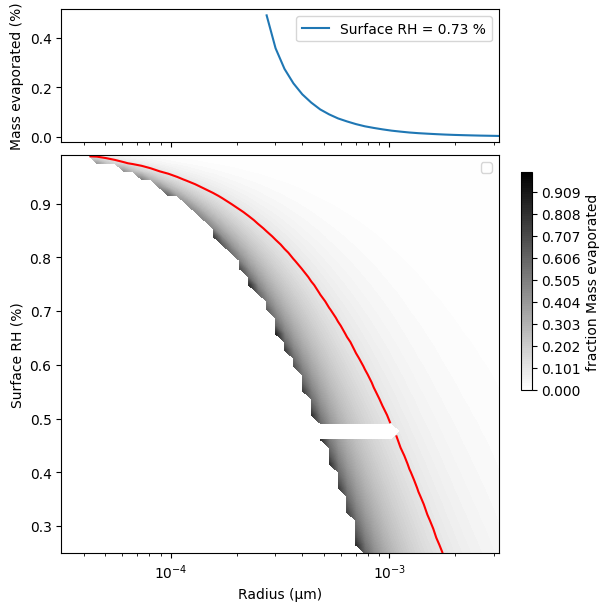

In [ ]:
row_data = output_matrix[18, ::-1]  # Reverse the row for plotting
fig,ax = plt.subplots(2, 1, figsize=(6, 6),sharex=True,gridspec_kw={"height_ratios": [1, 3]},constrained_layout=True)
ax[0].plot(radius_array,row_data, label=f"Surface RH = {RH_array[-18]:.2f} %")
ax[0].set_ylabel("Mass evaporated (%)")
ax[0].legend()

h = ax[1].contourf(
    radius_array,RH_array[::-1],
    output_matrix[:,::-1],  
    cmap="gray_r",          
    levels =np.linspace(0, 1, 100),  
    aspect="auto",       
    interpolation="bilinear",  
)
ax[1].set_xscale("log")  

# Add labels
ax[1].set_xlabel("Radius (µm)")
ax[1].set_ylabel("Surface RH (%)")

cbar = fig.colorbar(h, ax=ax, shrink=0.4)
cbar.set_label("fraction Mass evaporated")
contour_levels = [0.1]  # Define the level for the contour
ax[1].contour(radius_array,RH_array[::-1],output_matrix[:,::-1], levels=contour_levels, colors="red", linewidths=1.5,label="10% mass evaporated")
ax[1].legend()
plt.show()

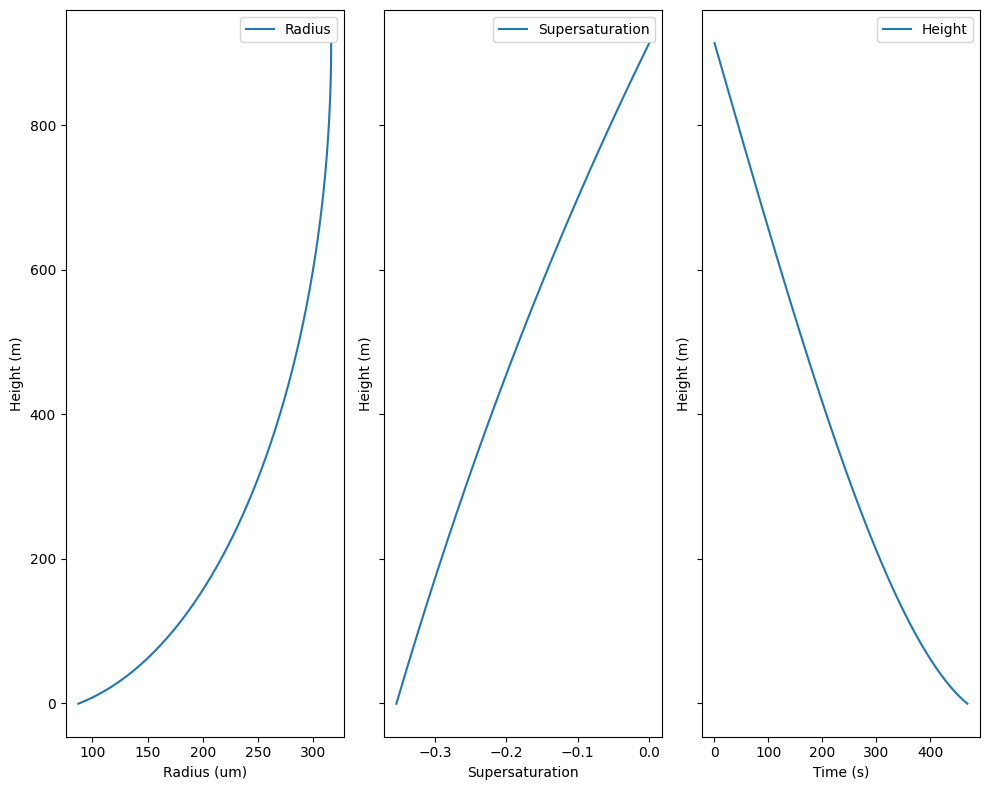

In [ ]:
fig,axs = plt.subplots(1, 3, figsize=(10, 8),sharey=True)
axs[0].plot(output["r"], output["z"], label="Radius")
axs[0].set_ylabel("Height (m)")
axs[0].set_xlabel("Radius (um)")
axs[0].legend()
axs[1].plot(output["S"], output["z"], label="Supersaturation")
axs[1].set_xlabel("Supersaturation")
axs[1].set_ylabel("Height (m)")
axs[1].legend()
axs[2].plot(output["t"], output["z"], label="Height")
axs[2].set_ylabel("Height (m)")
axs[2].set_xlabel("Time (s)")
axs[2].legend()
plt.tight_layout()